In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Input video

In [2]:
SOURCE_VIDEO_PATH = f"{HOME}/Bag Loading Conveyor.mp4"

In [3]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.202 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 27.1/78.2 GB disk)


In [4]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack


!sed -i 's/onnx==1.8.1/onnx==1.12.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric

!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [5]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [6]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [7]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [8]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [20]:
!unzip /content/weights.zip

Archive:  /content/weights.zip
   creating: runs/detect/train14/weights/
  inflating: runs/detect/train14/weights/last.pt  
  inflating: runs/detect/train14/weights/best.pt  
   creating: runs/detect/train16/weights/
  inflating: runs/detect/train16/weights/last.pt  
  inflating: runs/detect/train16/weights/best.pt  


In [17]:
%cd ..

/content


In [18]:
%pwd

'/content'

In [19]:
%ls

'Bag Loading Conveyor.mp4'   ByteTrack/   weights.zip


In [21]:
# settings
# MODEL = "yolov8x.pt"
# MODEL = "/content/yolov8s.pt"
MODEL = "/content/runs/detect/train16/weights/best.pt"

In [22]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


## Predict and annotate single frame

In [23]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - rice-bag
CLASS_ID = [0]


0: 384x640 6 rice-bags, 186.2ms
Speed: 22.9ms preprocess, 186.2ms inference, 20.6ms postprocess per image at shape (1, 3, 384, 640)


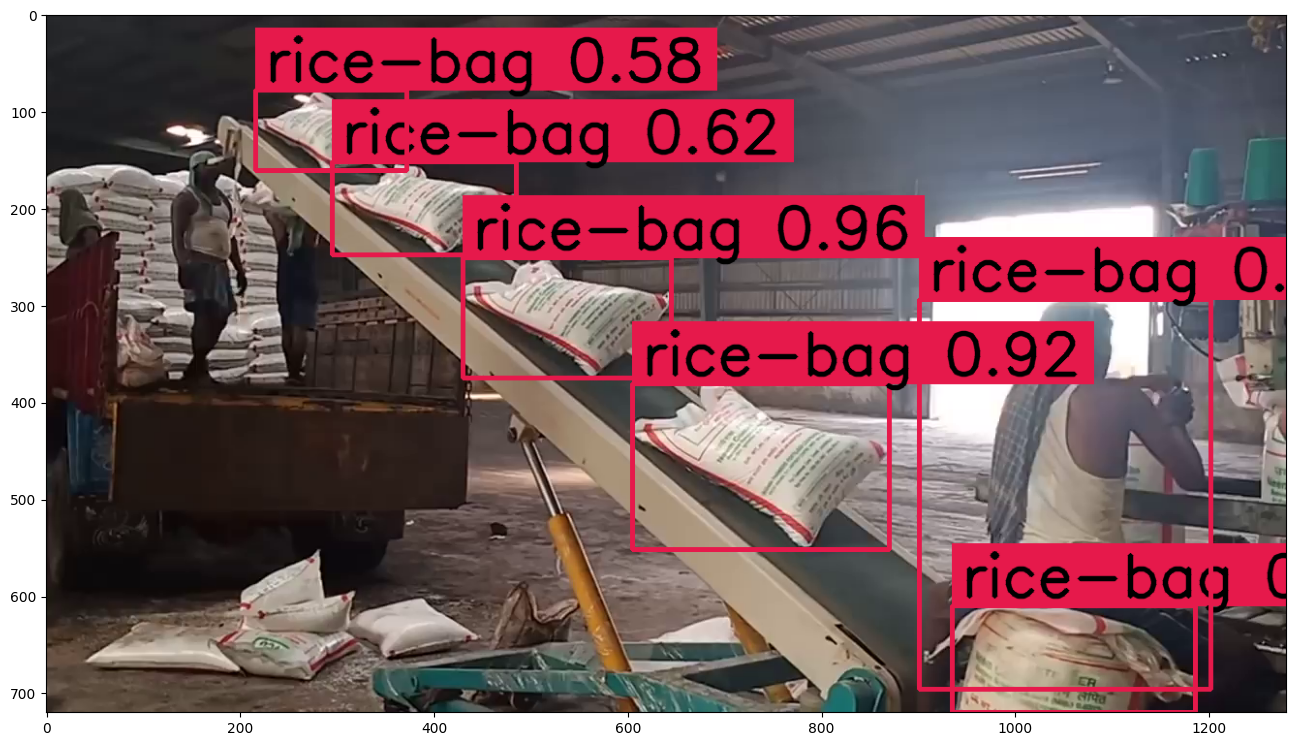

In [24]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

## Predict and annotate whole video

In [33]:
# settings
LINE_START = Point(300, 200)
LINE_END = Point(800, 200)

TARGET_VIDEO_PATH = f"{HOME}/rice-bag-counting-result.mp4"

In [34]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1280, height=720, fps=29, total_frames=1471)

In [35]:
from tqdm.notebook import tqdm


# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # updating line counter
        line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/1471 [00:00<?, ?it/s]


0: 384x640 6 rice-bags, 22.2ms
Speed: 2.2ms preprocess, 22.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 rice-bags, 11.1ms
Speed: 1.9ms preprocess, 11.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 rice-bags, 11.1ms
Speed: 1.8ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 rice-bags, 11.0ms
Speed: 3.4ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 rice-bags, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 rice-bags, 11.0ms
Speed: 1.5ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 rice-bags, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 rice-bags, 11.1ms
Speed: 1.9ms preprocess, 11.1ms inference, 1.5ms postprocess per 